In [1]:
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as Func
from torch.autograd import Variable
from torchinfo import summary

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

from torch.utils.data import Dataset, DataLoader
from torchinfo import summary

from tqdm.auto import tqdm

# own
import common.action as action
import common.world as world
import common.plot as plot
import common.preprocess as preprocess
import common.nets as nets
import common.train as train
import common.tools as tools

/Users/mariuskaestingschaefer/miniforge3/envs/pytorch/lib/python3.8/site-packages/seaborn/rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/Users/mariuskaestingschaefer/miniforge3/envs/pytorch/lib/python3.8/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/Users/mariuskaestingschaefer/miniforge3/envs/pytorch/lib/python3.8/site-packages/torch/utils/tensorboard/__init__.py:6: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, '__version__') or LooseVersion(tensorboard.__version__) < LooseVersion('1.15'):


In [2]:
with open("datasets/oracle_data.pickle", "rb") as handle:
    oracle_data = pickle.load(handle)

with open("datasets/oracle_reversed_data.pickle", "rb") as handle:
    oracle_reversed_data = pickle.load(handle)

with open("datasets/oracle_random_data.pickle", "rb") as handle:
    oracle_random_data = pickle.load(handle)

with open("datasets/oracle_reversed_random_data.pickle", "rb") as handle:
    oracle_reversed_random_data = pickle.load(handle)

with open("datasets/random_data.pickle", "rb") as handle:
    random_data = pickle.load(handle)

with open("datasets/tmaze_random_reverse_data.pickle", "rb") as handle:
    tmaze_random_reverse_data = pickle.load(handle)

with open("datasets/oracle_reversed_random_data_small.pickle", "rb") as handle:
    oracle_reversed_random_data_small = pickle.load(handle)

In [36]:
from matplotlib import pyplot as plt

positions = oracle_data['positions']
coords = [[i[0], i[2]] for i in positions]

x, y = [], []
for coord in coords:
    x.append(coord[0])
    y.append(coord[1])

plt.plot(x, y)
plt.show()

IndentationError: unexpected indent (2992201057.py, line 4)

In [127]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data) - seq_length - 1):
        _x = data[i : (i + seq_length)]
        _y = data[i + seq_length]  # _y = data[i+seq_length] (target)
        x.append(_x)
        y.append(_y)

    return np.array(x), np.array(y)  # train, val. data

def create_data(seq_length, data, shuffle = True):
    
    positions = data['positions']    
    coords = [[i[0], i[2]] for i in positions]
    training_data = coords

    x, y = sliding_windows(training_data, seq_length)

    # one method of performing the training and validation split
    train_size = int(len(y) * 0.80)
    test_size = len(y) - train_size


    # shuffle data first before splitting
    if shuffle:
        idx_shuf = list(range(len(y)))
        random.shuffle(idx_shuf)
        x = [x[i] for i in idx_shuf]
        y = [y[i] for i in idx_shuf]

    # split data
    dataX = Variable(torch.Tensor(np.array(x)))
    dataY = Variable(torch.Tensor(np.array(y)))

    trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
    trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

    testX = Variable(torch.Tensor(np.array(x[train_size : len(x)])))
    testY = Variable(torch.Tensor(np.array(y[train_size : len(y)])))
    
    return trainX, trainY, testX, testY

In [38]:
k = 6
print('sequence:', x[k])
print('label:', y[k])

print(len(y))

sequence: [[20.23741856 20.8477096 ]
 [20.08744066 20.84513463]
 [19.93746277 20.84255967]
 [19.78748487 20.8399847 ]
 [19.63750697 20.83740973]
 [19.48752908 20.83483476]
 [19.33755118 20.8322598 ]
 [19.18757328 20.82968483]
 [19.03759539 20.82710986]
 [18.88761749 20.8245349 ]]
label: [18.73763959 20.82195993]
1184


In [166]:
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()

        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
        )

        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))

        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        h_out = h_out.view(-1, self.hidden_size)
        out1 = self.fc(h_out)
        #out2 = self.fc(h_out)

        return out1 #, out2

# change weight initialization (kaiming_normal_
    
num_epochs = 2000
learning_rate = 0.001

input_size = 2
hidden_size = 300
num_layers = 1

num_classes = 2

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

In [167]:
value = 0

test_input = trainX[value:value+1]
print("input length:", len(test_input[0]))
print("input (trainX):", test_input)

#out1, out2 = lstm(test_input)
out1 = lstm(test_input)
print(out1)

print("outputs:", out1[0]) #
print("labels:", trainY[value:value+1])

print("")

#out1, out2 = lstm(trainX)
out1 = lstm(trainX)

print("length input (trainX):", len(trainX))
print("length outputs:", len(out1))
print("length labels:", len(trainY))

print("")
print("SUMMARY LSTM \n", summary(lstm, (600, 1, 2), device="cpu"))

input length: 1
input (trainX): tensor([[[22.1575,  5.1284]]])
tensor([[ 0.0645, -0.0716]], grad_fn=<AddmmBackward0>)
outputs: tensor([ 0.0645, -0.0716], grad_fn=<SelectBackward0>)
labels: tensor([[22.3075,  5.1309]])

length input (trainX): 954
length outputs: 954
length labels: 954

SUMMARY LSTM 
Layer (type:depth-idx)                   Output Shape              Param #
LSTM                                     [600, 2]                  --
├─LSTM: 1-1                              [600, 1, 300]             364,800
├─Linear: 1-2                            [600, 2]                  602
Total params: 365,402
Trainable params: 365,402
Non-trainable params: 0
Total mult-adds (M): 219.24
Input size (MB): 0.00
Forward/backward pass size (MB): 1.45
Params size (MB): 1.46
Estimated Total Size (MB): 2.92


In [41]:
def separate_coordinates(coords):

    coord1, coord2 = [], []
    for coord in coords:
        coord1.append(coord[0].tolist() * 10)
        coord2.append(coord[1].tolist() * 10)
        #coord2 = coord2 + list(coord[1].tolist())
        
    coord1 = torch.FloatTensor(coord1)
    coord2 = torch.FloatTensor(coord2)
        
    return coord1, coord2

coord1_trainY, coord2_trainY =  separate_coordinates(trainY)
coord1_testY, coord2_testY =  separate_coordinates(testY)

In [85]:
def plot_losses(test_loss, train_loss, num_epochs):
    
    for i in range(len(train_loss)):
        train_loss[i] = train_loss[i].item()
    
    font = 24
    hfont = {'fontname':'Helvetica'}
        
    plt.rcParams["figure.figsize"] = 20, 6
    plt.rcParams['axes.titlepad'] = 13 
    plt.rcParams['xtick.major.pad']='8' # axis distance
    plt.rcParams['ytick.major.pad']='8'
    
    plt.rc("xtick", labelsize=font)
    plt.rc("ytick", labelsize=font)

    
    with plt.style.context("seaborn-darkgrid"):
        
        plt.rcParams.update({"font.size": font})
        plt.plot(test_loss, color="slategray", linewidth=2)
        plt.plot(train_loss, color="red", linewidth=2)
        plt.legend(["Training Loss", "Validation Loss"])
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title("Loss")
        
        # plt.savefig('difficult_env_loss_epochs.pdf', bbox_inches="tight")
        plt.show()

def plot_euclidean_distance(train_dis, test_dis, num_epochs):
    
    
    for i in range(len(train_dis)):
        train_dis[i] = train_dis[i].item()
    
    #for i in range(len(test_dis)):
    #    test_dis[i] = test_dis[i].item()  

    font = 24
    hfont = {'fontname':'Helvetica'}
        
    plt.rcParams["figure.figsize"] = 20, 6
    plt.rcParams['axes.titlepad'] = 13 
    plt.rcParams['xtick.major.pad']='8' # axis distance
    plt.rcParams['ytick.major.pad']='8'
    
    plt.rc("xtick", labelsize=font)
    plt.rc("ytick", labelsize=font)

    plt.rcParams.update({"font.size": font})

    with plt.style.context("seaborn-darkgrid"):
        plt.plot(train_dis, label="Training", linewidth=3, color="tab:blue")
        plt.plot(test_dis, c='indianred', label="Validation", linewidth=3)
        plt.title("Difficult Environment", fontsize=font)
        plt.legend(fontsize=font)
        plt.xlabel("Epochs", fontsize=font, **hfont)
        plt.ylabel("Euclidean distance", fontsize=font, **hfont)
        
        plt.xlim(xmax = num_epochs+5, xmin = -5)
        
        #plt.savefig('difficult_env_euclidean_distance_epochs.pdf', bbox_inches="tight")
        
        plt.show()


In [86]:
def train_lstm(num_epochs, trainX, trainY, testX, testY):
    
    lstm = LSTM(num_classes, input_size, hidden_size, num_layers)
    
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

    train_loss_collector = []
    train_distance_collector = []
    test_loss_collector = []
    test_distance_collector = []

    for epoch in range(num_epochs):

        optimizer.zero_grad()
        output = lstm(trainX)
        loss = criterion(output, trainY)
        loss.backward()

        # compute euclidean distance 
        train_dist = 0
        for idx, _ in enumerate(trainY):
            train_dist += ((output[idx][0] - trainY[idx][0])**2 + (output[idx][1] - trainY[idx][1])**2) ** 0.5
        train_dist = train_dist/len(trainY)

        with torch.no_grad():
            output_test = lstm(testX)
            loss_test = criterion(output_test, testY)

            test_dist = 0
            for idx, _ in enumerate(testY):
                test_dist += ((output_test[idx][0] - testY[idx][0])**2 + (output_test[idx][1] - testY[idx][1])**2) ** 0.5
            test_dist = test_dist/len(testY)

        train_loss_collector.append(loss)
        train_distance_collector.append(train_dist)
        test_loss_collector.append(loss_test)
        test_distance_collector.append(test_dist)

        optimizer.step()
        if epoch % (num_epochs/20) == 0:
            print("Epoch: %d, train loss: %1.5f, train distance: %1.5f, test loss: %1.5f, test distance: %1.5f" % (epoch, loss.item(), train_dist, loss_test.item(), test_dist))
        
    return train_loss_collector, train_distance_collector, test_loss_collector, test_distance_collector
            
            


sequence lenth 1 easy environment
Epoch: 0, train loss: 265.35565, train distance: 22.33841, test loss: 163.74004, test distance: 17.42937
Epoch: 25, train loss: 182.32176, train distance: 18.49476, test loss: 116.40820, test distance: 14.62381
Epoch: 50, train loss: 72.37878, train distance: 11.53087, test loss: 54.00231, test distance: 9.66400
Epoch: 75, train loss: 29.40058, train distance: 7.06147, test loss: 37.65366, test distance: 8.01972
Epoch: 100, train loss: 23.81995, train distance: 6.26988, test loss: 37.42773, test distance: 8.19399
Epoch: 125, train loss: 17.59111, train distance: 5.36906, test loss: 27.01734, test distance: 6.87875
Epoch: 150, train loss: 11.25174, train distance: 4.24727, test loss: 17.66640, test distance: 5.53447
Epoch: 175, train loss: 6.44078, train distance: 3.16267, test loss: 10.16196, test distance: 4.14947
Epoch: 200, train loss: 3.83011, train distance: 2.42065, test loss: 5.89039, test distance: 3.08894
Epoch: 225, train loss: 2.68990, trai

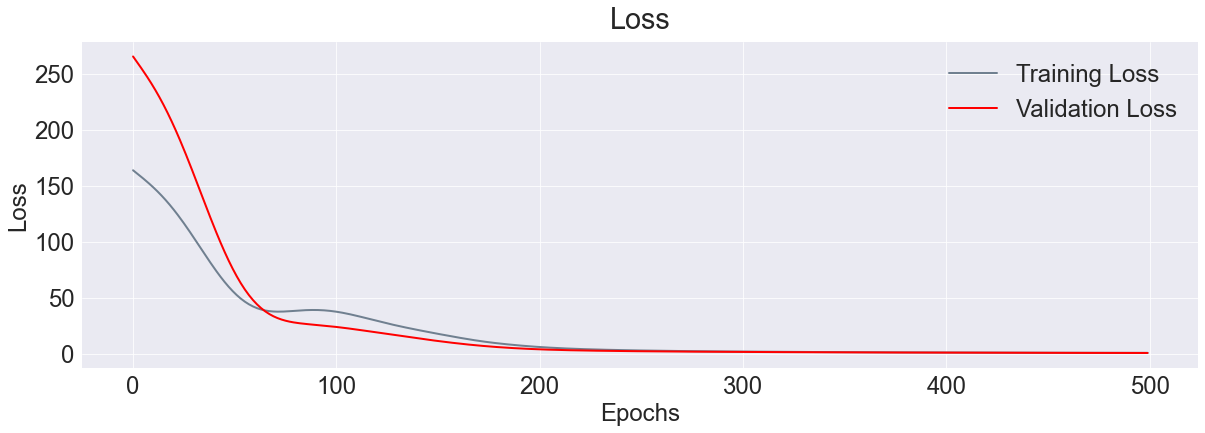

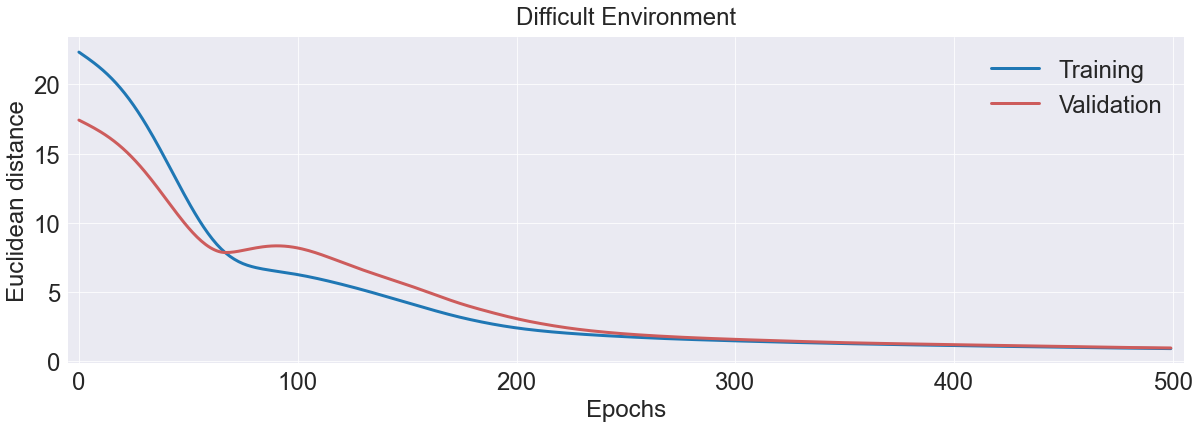


sequence lenth 11 easy environment
Epoch: 0, train loss: 264.17740, train distance: 22.31043, test loss: 161.59520, test distance: 17.32210
Epoch: 25, train loss: 66.79902, train distance: 10.75337, test loss: 41.23332, test distance: 8.17735
Epoch: 50, train loss: 30.31705, train distance: 7.15320, test loss: 45.92871, test distance: 9.18799
Epoch: 75, train loss: 23.71404, train distance: 6.13823, test loss: 44.41617, test distance: 8.98704
Epoch: 100, train loss: 17.79268, train distance: 5.22904, test loss: 32.22618, test distance: 7.53902
Epoch: 125, train loss: 9.71278, train distance: 3.69945, test loss: 16.15042, test distance: 5.03895
Epoch: 150, train loss: 3.76581, train distance: 2.19174, test loss: 6.40085, test distance: 3.11983
Epoch: 175, train loss: 1.86228, train distance: 1.60918, test loss: 3.24459, test distance: 2.13829
Epoch: 200, train loss: 0.91669, train distance: 1.04841, test loss: 2.04537, test distance: 1.72268
Epoch: 225, train loss: 0.58483, train dista

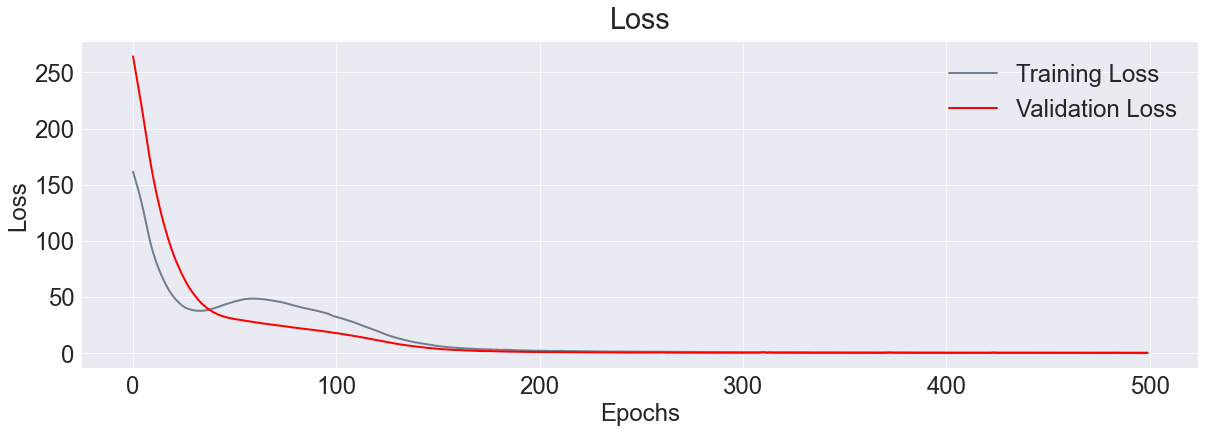

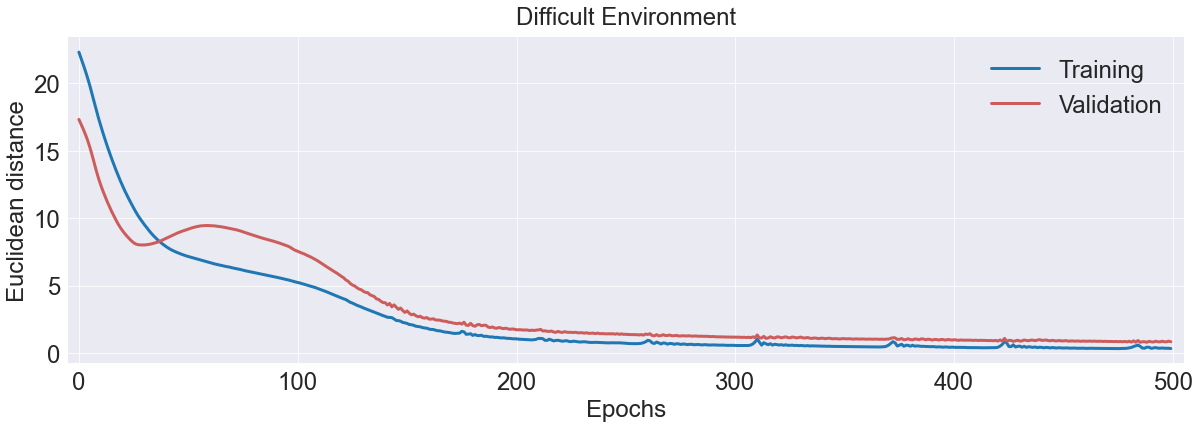


sequence lenth 21 easy environment
Epoch: 0, train loss: 267.50769, train distance: 22.47032, test loss: 163.10474, test distance: 17.40138
Epoch: 25, train loss: 64.98719, train distance: 10.60112, test loss: 36.10631, test distance: 7.65050
Epoch: 50, train loss: 27.93999, train distance: 6.88742, test loss: 40.67502, test distance: 8.60528
Epoch: 75, train loss: 21.17990, train distance: 5.80493, test loss: 40.90550, test distance: 8.60987
Epoch: 100, train loss: 13.38725, train distance: 4.47514, test loss: 26.07331, test distance: 6.72160
Epoch: 125, train loss: 6.25347, train distance: 2.90151, test loss: 11.22808, test distance: 4.09090
Epoch: 150, train loss: 2.42088, train distance: 1.72287, test loss: 4.20129, test distance: 2.50843
Epoch: 175, train loss: 1.19051, train distance: 1.21818, test loss: 2.34808, test distance: 1.89550
Epoch: 200, train loss: 0.64175, train distance: 0.85861, test loss: 1.57472, test distance: 1.54813
Epoch: 225, train loss: 0.46841, train dista

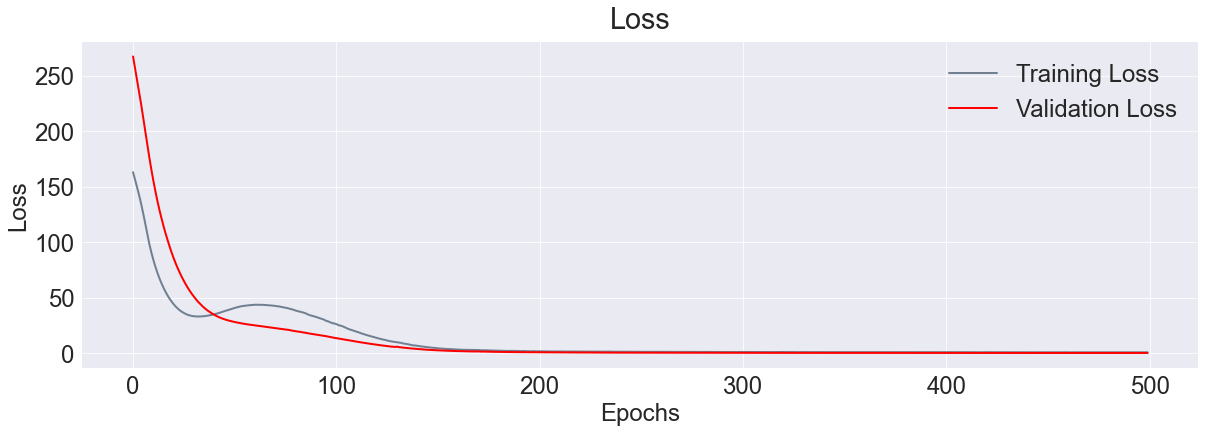

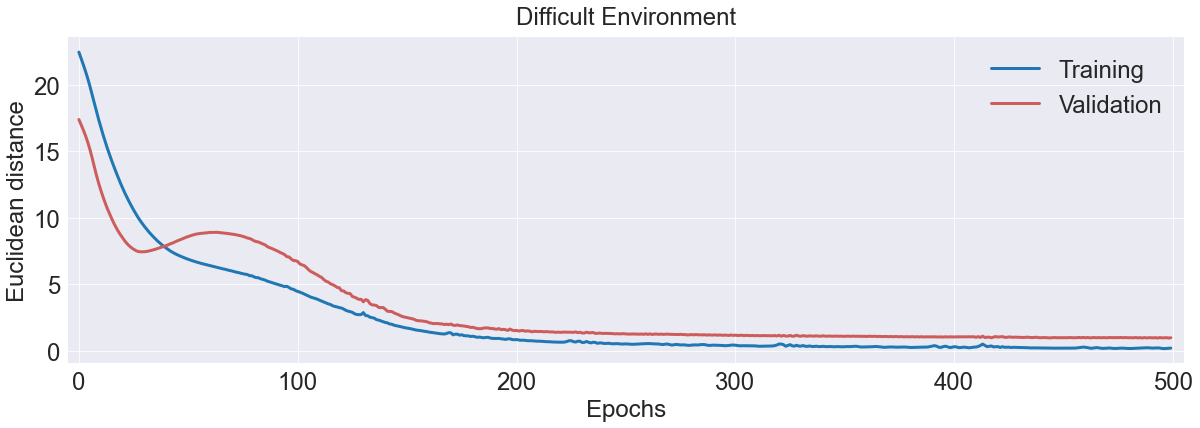


sequence lenth 1 medium environment
Epoch: 0, train loss: 150.95776, train distance: 16.79035, test loss: 186.36159, test distance: 18.52411
Epoch: 25, train loss: 103.09114, train distance: 13.87436, test loss: 131.09821, test distance: 15.49498
Epoch: 50, train loss: 40.56717, train distance: 8.54246, test loss: 61.34145, test distance: 10.51888
Epoch: 75, train loss: 17.89072, train distance: 5.39355, test loss: 29.79200, test distance: 7.43848
Epoch: 100, train loss: 10.47794, train distance: 4.07185, test loss: 15.33948, test distance: 5.34707
Epoch: 125, train loss: 4.89008, train distance: 2.71056, test loss: 8.24166, test distance: 3.91184
Epoch: 150, train loss: 2.09593, train distance: 1.76935, test loss: 4.24396, test distance: 2.80730
Epoch: 175, train loss: 1.29806, train distance: 1.48450, test loss: 2.51965, test distance: 2.12948
Epoch: 200, train loss: 0.98891, train distance: 1.28772, test loss: 1.84301, test distance: 1.76856
Epoch: 225, train loss: 0.79910, train d

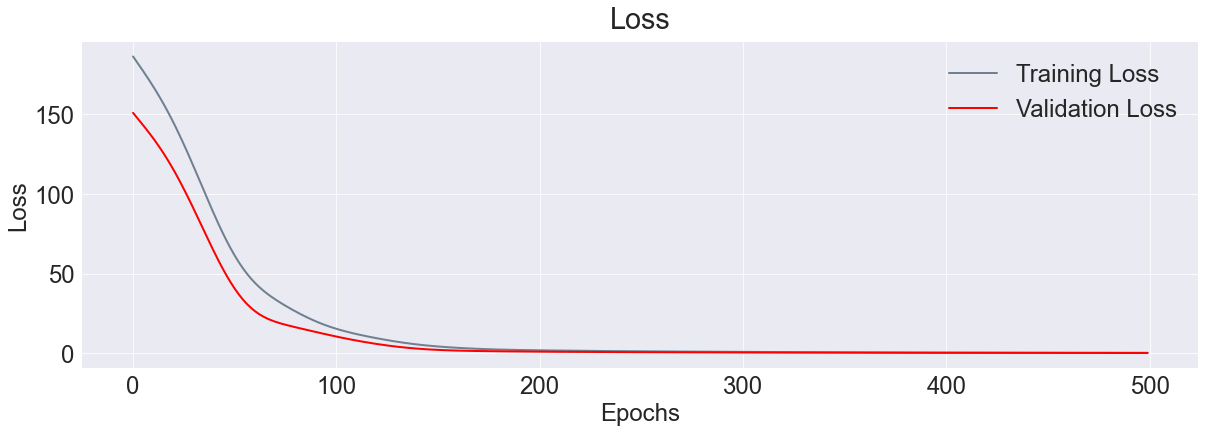

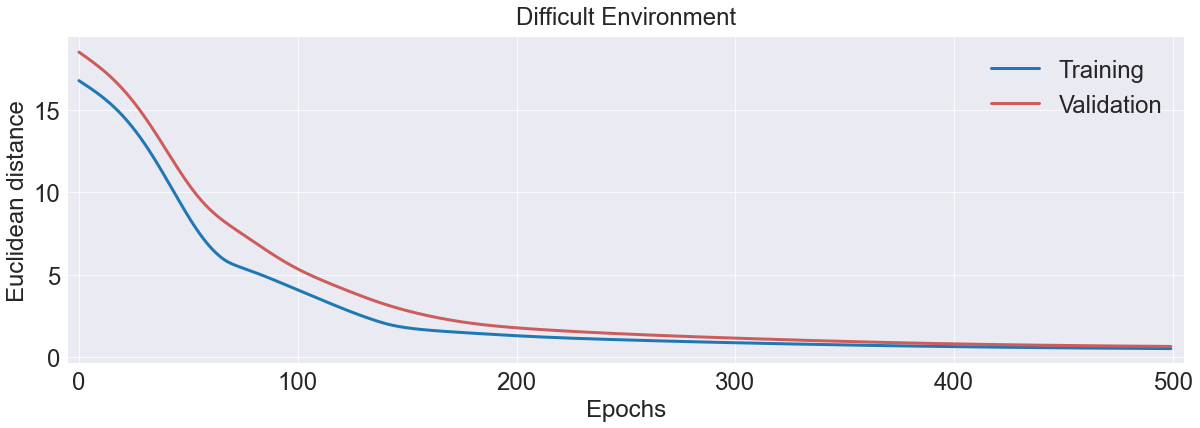


sequence lenth 11 medium environment
Epoch: 0, train loss: 153.05801, train distance: 16.91412, test loss: 189.04855, test distance: 18.66689
Epoch: 25, train loss: 27.32520, train distance: 6.46830, test loss: 51.35775, test distance: 9.72017
Epoch: 50, train loss: 9.90724, train distance: 3.76929, test loss: 20.40985, test distance: 6.22050
Epoch: 75, train loss: 4.40322, train distance: 2.41604, test loss: 11.65138, test distance: 4.66163
Epoch: 100, train loss: 2.37843, train distance: 1.79904, test loss: 6.18719, test distance: 3.36796
Epoch: 125, train loss: 0.69133, train distance: 0.95378, test loss: 1.69199, test distance: 1.60844
Epoch: 150, train loss: 0.30997, train distance: 0.62704, test loss: 0.79934, test distance: 1.07325
Epoch: 175, train loss: 0.15045, train distance: 0.43788, test loss: 0.50276, test distance: 0.89456
Epoch: 200, train loss: 0.09552, train distance: 0.36371, test loss: 0.34106, test distance: 0.73091
Epoch: 225, train loss: 0.06365, train distance:

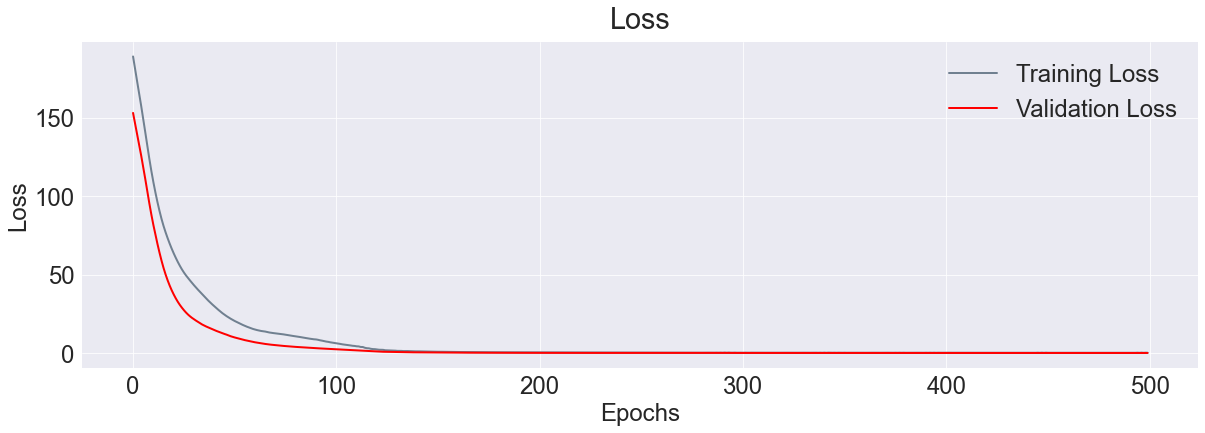

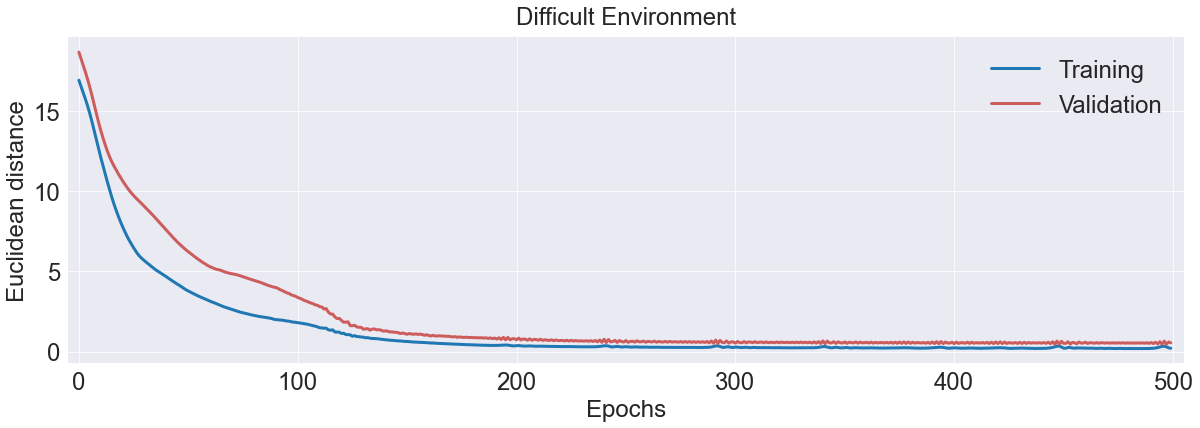


sequence lenth 21 medium environment
Epoch: 0, train loss: 153.51692, train distance: 16.96301, test loss: 186.63109, test distance: 18.52963
Epoch: 25, train loss: 27.46326, train distance: 6.57020, test loss: 49.45810, test distance: 9.61962
Epoch: 50, train loss: 13.65844, train distance: 4.49750, test loss: 21.86945, test distance: 6.44942
Epoch: 75, train loss: 6.22626, train distance: 3.02545, test loss: 14.64457, test distance: 5.27080
Epoch: 100, train loss: 3.73117, train distance: 2.28053, test loss: 10.55770, test distance: 4.46229
Epoch: 125, train loss: 1.65702, train distance: 1.58232, test loss: 4.29845, test distance: 2.84721
Epoch: 150, train loss: 0.52286, train distance: 0.85546, test loss: 1.40057, test distance: 1.50763
Epoch: 175, train loss: 0.22440, train distance: 0.54967, test loss: 0.78044, test distance: 1.15761
Epoch: 200, train loss: 0.11855, train distance: 0.39468, test loss: 0.50881, test distance: 0.92129
Epoch: 225, train loss: 0.08067, train distanc

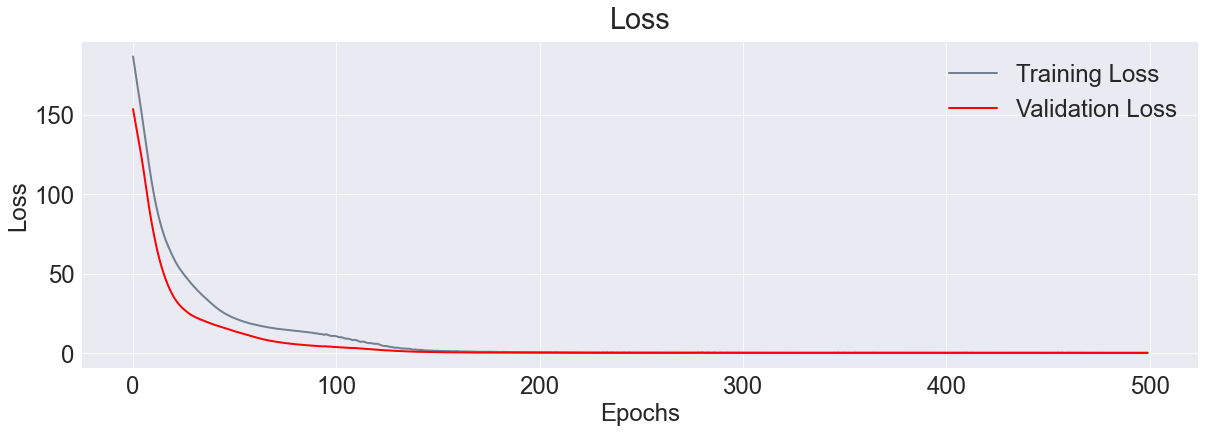

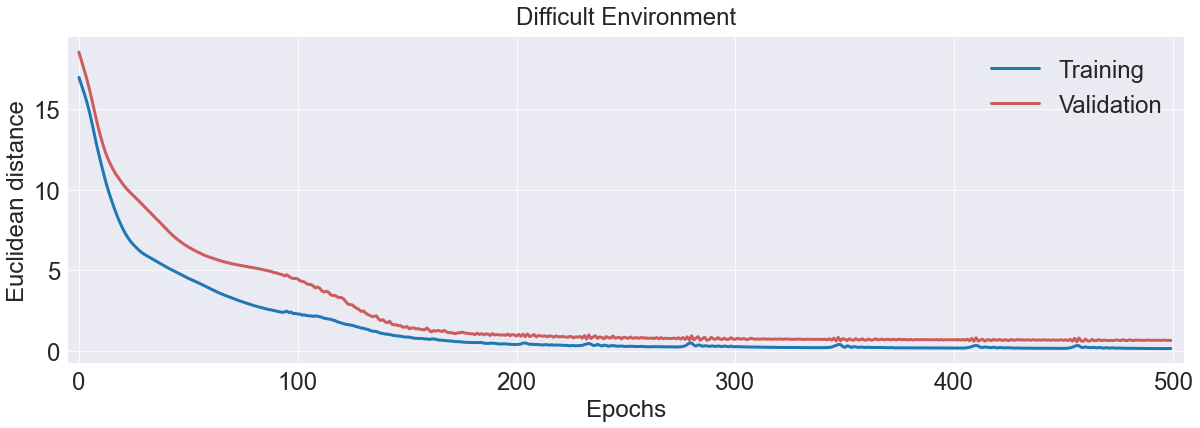


sequence lenth 1 difficult environment
Epoch: 0, train loss: 5.04025, train distance: 2.93206, test loss: 0.40562, test distance: 0.80700
Epoch: 25, train loss: 3.25764, train distance: 2.35146, test loss: 0.38501, test distance: 0.80279
Epoch: 50, train loss: 1.03548, train distance: 1.31682, test loss: 0.56438, test distance: 1.02783
Epoch: 75, train loss: 0.39869, train distance: 0.73689, test loss: 0.88018, test distance: 1.29691
Epoch: 100, train loss: 0.22117, train distance: 0.57541, test loss: 0.54199, test distance: 1.02792
Epoch: 125, train loss: 0.09028, train distance: 0.36855, test loss: 0.33142, test distance: 0.80378
Epoch: 150, train loss: 0.03399, train distance: 0.22026, test loss: 0.22259, test distance: 0.63764
Epoch: 175, train loss: 0.02317, train distance: 0.18216, test loss: 0.17171, test distance: 0.53872
Epoch: 200, train loss: 0.01980, train distance: 0.17210, test loss: 0.14288, test distance: 0.48026
Epoch: 225, train loss: 0.01763, train distance: 0.16327

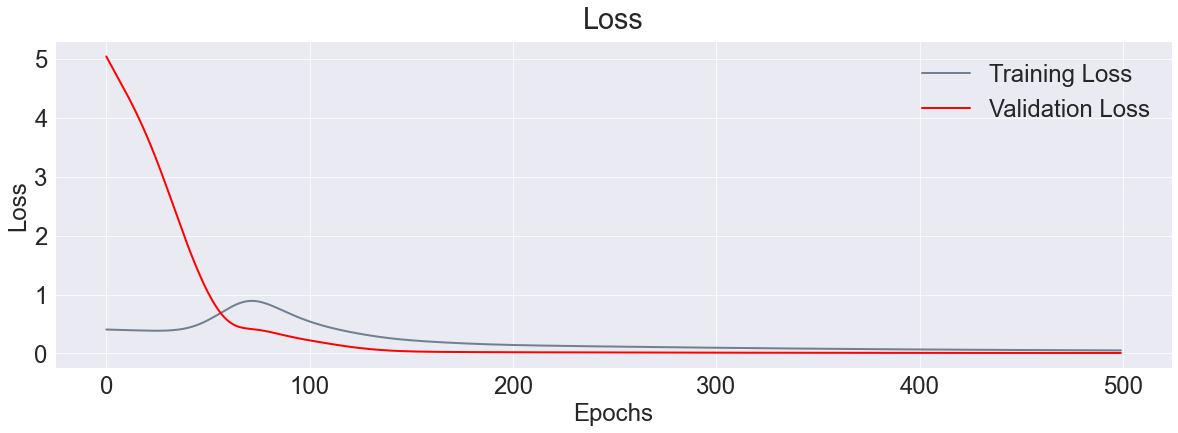

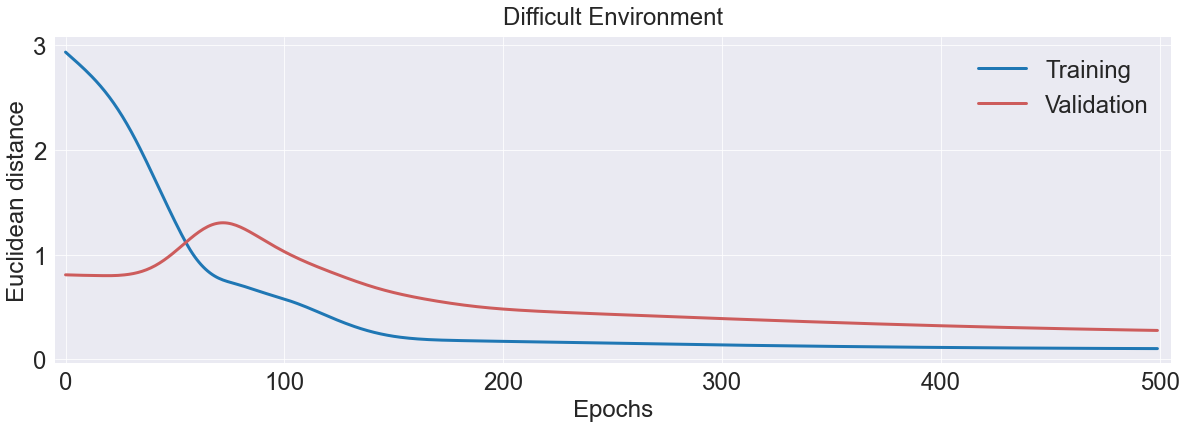


sequence lenth 11 difficult environment
Epoch: 0, train loss: 4.92533, train distance: 2.90289, test loss: 0.39637, test distance: 0.78865
Epoch: 25, train loss: 0.32783, train distance: 0.73384, test loss: 0.25375, test distance: 0.64631
Epoch: 50, train loss: 0.07620, train distance: 0.33883, test loss: 0.12680, test distance: 0.47018
Epoch: 75, train loss: 0.03553, train distance: 0.23250, test loss: 0.08446, test distance: 0.37129
Epoch: 100, train loss: 0.02556, train distance: 0.19447, test loss: 0.05758, test distance: 0.28614
Epoch: 125, train loss: 0.02241, train distance: 0.17979, test loss: 0.05243, test distance: 0.26872
Epoch: 150, train loss: 0.02048, train distance: 0.16969, test loss: 0.05163, test distance: 0.26413
Epoch: 175, train loss: 0.01904, train distance: 0.16230, test loss: 0.05189, test distance: 0.26412
Epoch: 200, train loss: 0.01785, train distance: 0.15646, test loss: 0.05243, test distance: 0.26531
Epoch: 225, train loss: 0.01679, train distance: 0.1514

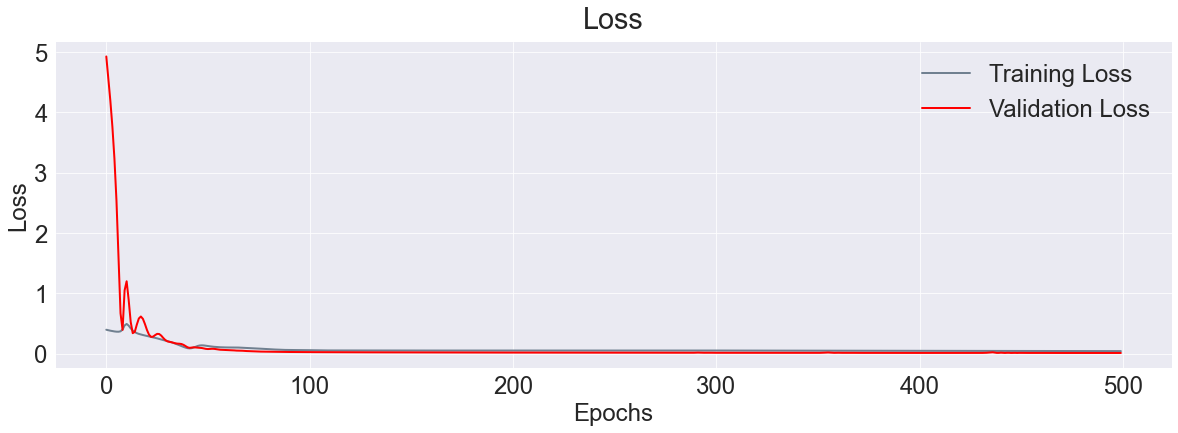

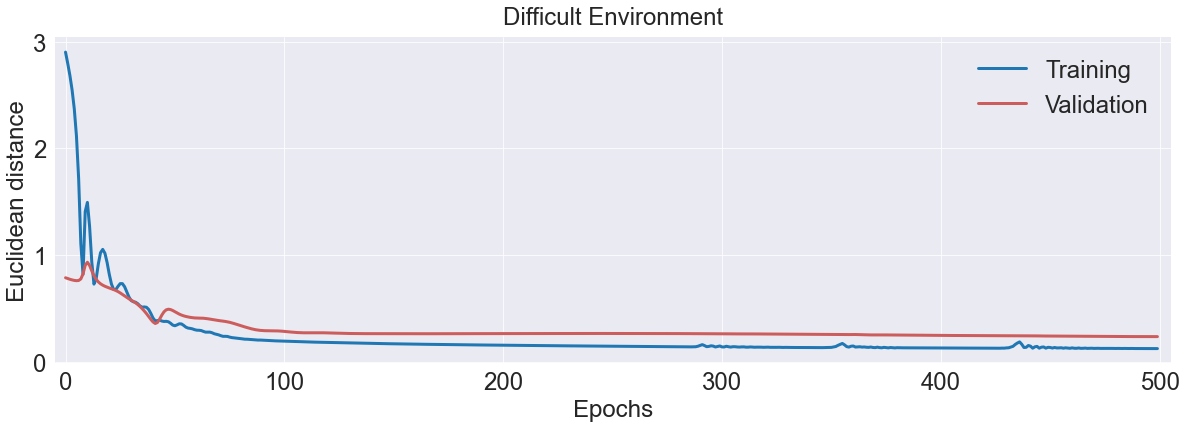


sequence lenth 21 difficult environment
Epoch: 0, train loss: 4.85143, train distance: 2.86359, test loss: 0.37261, test distance: 0.77718
Epoch: 25, train loss: 0.22929, train distance: 0.60162, test loss: 0.23858, test distance: 0.62699
Epoch: 50, train loss: 0.09976, train distance: 0.39251, test loss: 0.20790, test distance: 0.60305
Epoch: 75, train loss: 0.05224, train distance: 0.28020, test loss: 0.13881, test distance: 0.46580
Epoch: 100, train loss: 0.02436, train distance: 0.18759, test loss: 0.09297, test distance: 0.36017
Epoch: 125, train loss: 0.02097, train distance: 0.17057, test loss: 0.08732, test distance: 0.34758
Epoch: 150, train loss: 0.01897, train distance: 0.16120, test loss: 0.08449, test distance: 0.34130
Epoch: 175, train loss: 0.01740, train distance: 0.15396, test loss: 0.08074, test distance: 0.33274
Epoch: 200, train loss: 0.01604, train distance: 0.14796, test loss: 0.07693, test distance: 0.32392
Epoch: 225, train loss: 0.01498, train distance: 0.1433

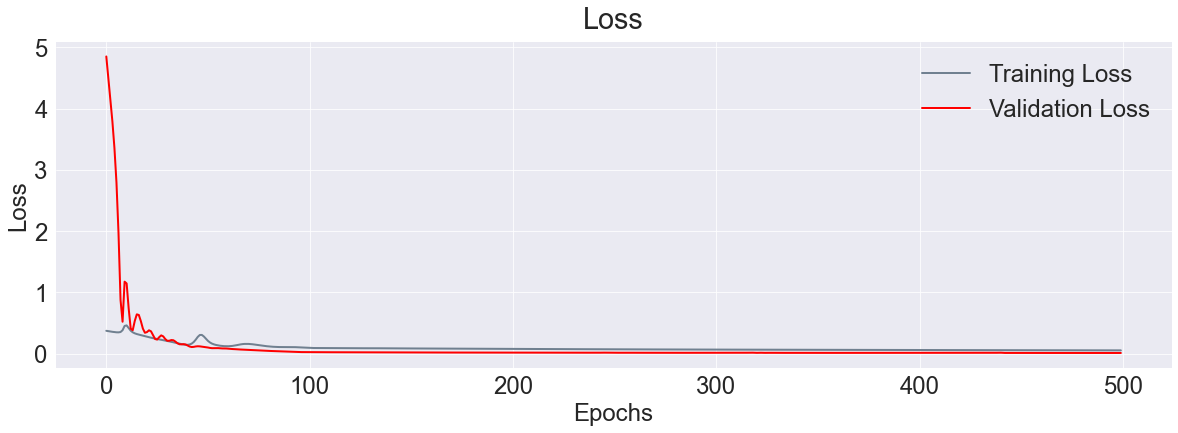

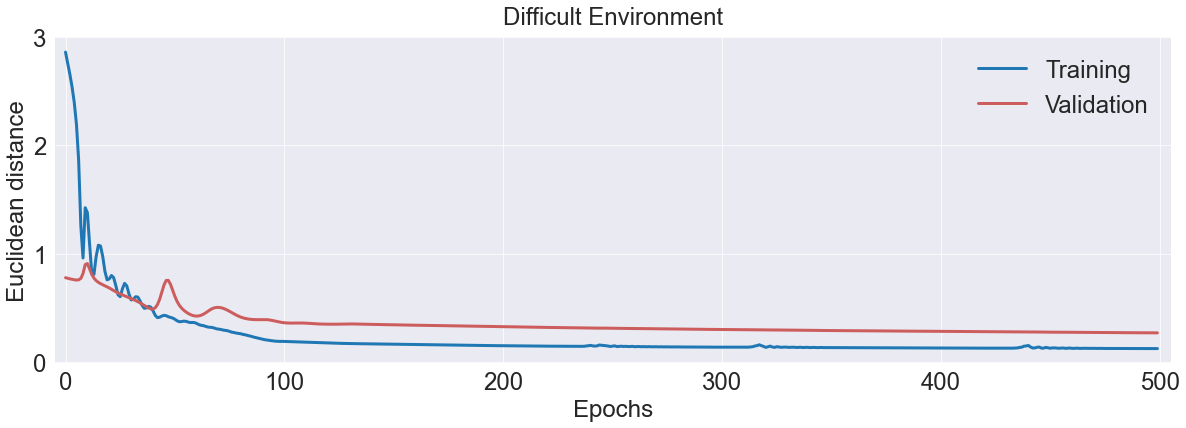

In [162]:
def run_all_environments(environments):

    meta_meta_train_distance_collector = []
    meta_meta_test_distance_collector = []

    for idx, data in enumerate(environments):

        learning_rate = 0.001

        input_size = 2
        hidden_size = 300
        num_layers = 1

        num_classes = 2

        num_epochs = 500

        meta_train_distance_collector = []
        meta_test_distance_collector = []

        for i in range(1, 22, 10):

            print('')
            if idx == 0: print('sequence lenth', i, 'easy environment')
            if idx == 1: print('sequence lenth', i, 'medium environment')
            if idx == 2: print('sequence lenth', i, 'difficult environment')
            seq_length = i
            shuffle = True

            trainX, trainY, testX, testY = create_data(seq_length, data, shuffle = False)

            train_loss_collector, train_distance_collector, test_loss_collector, test_distance_collector = train_lstm(num_epochs, trainX, trainY, testX, testY)

            plot_losses(test_loss_collector, train_loss_collector, num_epochs)
            plot_euclidean_distance(train_distance_collector, test_distance_collector, num_epochs)

            meta_train_distance_collector.append(train_distance_collector)
            meta_test_distance_collector.append(test_distance_collector)
        
        meta_meta_train_distance_collector.append(meta_train_distance_collector)
        meta_meta_test_distance_collector.append(meta_test_distance_collector)
        
    return meta_meta_train_distance_collector, meta_meta_test_distance_collector

environments = [oracle_reversed_data, oracle_reversed_random_data_small, tmaze_random_reverse_data]

# 3 environments x 3 sequence lenghts x actual runs
train_distances, test_distances = run_all_environments(environments)



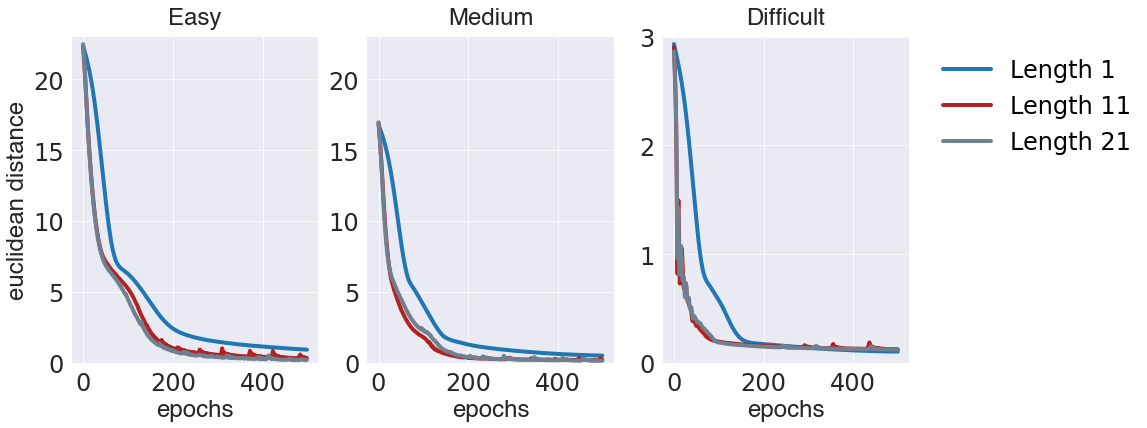

In [164]:
font = 24
hfont = {'fontname':'Helvetica'}

#plt.rcParams["figure.figsize"] = 25, 5.5
plt.rcParams.update({"font.size": font})
plt.rcParams['axes.titlepad'] = 13 
plt.rcParams['xtick.major.pad']='8' # axis distance
plt.rcParams['ytick.major.pad']='8'

plt.figure(figsize=(15, 6))

with plt.style.context("seaborn-darkgrid"):

    plt.rc("xtick", labelsize=font)
    plt.rc("ytick", labelsize=font)

    plt.title("Model performance", fontsize=font)
    plt.ylabel("validation accuracy", fontsize=font, **hfont)
    plt.xlabel("n-step distance", fontsize=font, **hfont)

    # easy
    plt.subplot(1, 3, 1)
    y1, = plt.plot(train_distances[0][0], linestyle='solid', c='tab:blue', label='Length 1', linewidth=4.0)
    y2, = plt.plot(train_distances[0][1], c='firebrick', linestyle='solid', label='Length 11', linewidth=4.0)
    y3, = plt.plot(train_distances[0][2], c='slategray', linestyle='solid', label='Length 21', linewidth=4.0)
    
    #plt.xticks(np.arange(min(x), max(x)+1, 1.0))
    plt.ylim(ymax = 23, ymin = 0)
    plt.yticks(np.arange(0, 22.5+1, 5.0))
    plt.ylabel("euclidean distance", fontsize=font, **hfont)
    plt.xlabel("epochs", fontsize=font, **hfont)
    plt.title("Easy", fontsize=font, **hfont)
        
    plt.subplot(1, 3, 2)
    plt.plot(train_distances[1][0], linestyle='solid', c='tab:blue', label='Length 1', linewidth=4.0)
    plt.plot(train_distances[1][1], c='firebrick', linestyle='solid', label='Length 9', linewidth=4.0)
    plt.plot(train_distances[1][2], c='slategray', linestyle='solid', label='Length 17', linewidth=4.0)
    
    #plt.xticks(np.arange(min(x), max(x)+1, 1.0))
    plt.ylim(ymax = 23, ymin = 0)
    plt.yticks(np.arange(0, 22.5+1, 5.0))
    plt.xlabel("epochs", fontsize=font, **hfont)
    plt.title("Medium", fontsize=font, **hfont)

    plt.subplot(1, 3, 3)
    plt.plot(train_distances[2][0], linestyle='solid', c='tab:blue', label='Length 1', linewidth=4.0)
    plt.plot(train_distances[2][1], c='firebrick', linestyle='solid', label='Length 9', linewidth=4.0)
    plt.plot(train_distances[2][2], c='slategray', linestyle='solid', label='Length 17', linewidth=4.0)
    
    #plt.xticks(np.arange(min(x), max(x)+1, 1.0))
    plt.ylim(ymax = 3, ymin = 0)
    plt.yticks(np.arange(0, 3+0.1, 1))
    plt.xlabel("epochs", fontsize=font, **hfont)
    plt.title("Difficult", fontsize=font, **hfont)
    
plt.legend(handles=[y1, y2, y3], bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)
plt.savefig('lstm_coordinate_pred_train_set_shuffle_False.pdf', bbox_inches="tight")
plt.show()